## Load libraries

In [1]:
# Packages
import numpy as np
import pandas as pd
import re
import spacy
import nltk
from emot.emo_unicode import UNICODE_EMO, EMOTICONS
from io import StringIO
from html.parser import HTMLParser
import string
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer, TreebankWordTokenizer 
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.utils import resample

# Visualisations
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Vectorisers
from sklearn.feature_extraction.text import TfidfVectorizer

# Training
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV

# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# Model evaluation
from sklearn.metrics import confusion_matrix, classification_report, f1_score, make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Save models
import pickle

In [2]:
nlp = spacy.load('en_core_web_sm')

In [3]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\rober\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Load the datasets

In [4]:
sample_submission = pd.read_csv('sample_submission.csv')
train = pd.read_csv('train.csv')
train.set_index('tweetid', inplace=True)

test = pd.read_csv('test.csv')
test.set_index('tweetid', inplace=True)

print('Train data shape: ', train.shape, 'Test data shape: ', test.shape)

Train data shape:  (15819, 2) Test data shape:  (10546, 1)


In [5]:
# View the training data
train.head()

,sentiment,message
tweetid,,
625221,1,PolySciMajor EPA chief doesn't think carbon di...
126103,1,It's not like we lack evidence of anthropogeni...
698562,2,RT @RawStory: Researchers say we have three ye...
573736,1,#TodayinMaker# WIRED : 2016 was a pivotal year...
466954,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ..."


In [6]:
# View the test data
test.head()

,message
tweetid,
169760,Europe will now be looking to China to make su...
35326,Combine this with the polling of staffers re c...
224985,"The scary, unimpeachable evidence that climate..."
476263,@Karoli @morgfair @OsborneInk @dailykos \nPuti...
872928,RT @FakeWillMoore: 'Female orgasms cause globa...


## Data preprocessing

In [7]:
# Remove html tags from messages
from io import StringIO
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.text = StringIO()
    def handle_data(self, d):
        self.text.write(d)
    def get_data(self):
        return self.text.getvalue()

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

train['clean_msg'] = train['message'].apply(strip_tags)
test['clean_msg'] = test['message'].apply(strip_tags)

In [8]:
# Remove urls, new lines and hashtags from training data
re_pattern = [r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*']
train['clean_msg'] = train['clean_msg'].replace(to_replace = re_pattern, 
                                          value = r'website', regex = True)
train['clean_msg'] = train['clean_msg'].replace(to_replace = r'\n', 
                                          value = r'', regex = True)
train['clean_msg'] = train['clean_msg'].replace(to_replace = r'@', 
                                          value = r'twitterhandle ', regex = True)

# Remove urls, new lines and hashtags from test data
test['clean_msg'] = test['clean_msg'].replace(to_replace = re_pattern, 
                                                    value = r'website', regex = True)
test['clean_msg'] = test['clean_msg'].replace(to_replace = r'\n', 
                                                    value = r'', regex = True)
test['clean_msg'] = test['clean_msg'].replace(to_replace = r'@', 
                                                    value = r'twitterhandle ', regex = True)

In [9]:
train.head()

,sentiment,message,clean_msg
tweetid,,,
625221,1,PolySciMajor EPA chief doesn't think carbon di...,PolySciMajor EPA chief doesn't think carbon di...
126103,1,It's not like we lack evidence of anthropogeni...,It's not like we lack evidence of anthropogeni...
698562,2,RT @RawStory: Researchers say we have three ye...,RT twitterhandle RawStory: Researchers say we ...
573736,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,#TodayinMaker# WIRED : 2016 was a pivotal year...
466954,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...","RT twitterhandle SoyNovioDeTodas: It's 2016, a..."


In [10]:
# Converting the emoticons into text 
!pip install emot --upgrade
from emot.emo_unicode import UNICODE_EMO, EMOTICONS
def convert_emojis(text):
    for emot in UNICODE_EMO:
        text = text.replace(emot, "_".join(UNICODE_EMO[emot].replace(",","").
                                           replace(":","").split()))
        return text
# Function which will change the emoji to a string
def emoji_remove(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"  # 
                           u"\U000024C2-\U0001F251"  # 
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

train['clean_msg'] = train['clean_msg'].apply(convert_emojis)
train['clean_msg'] = train['clean_msg'].apply(emoji_remove)

test['clean_msg'] = test['clean_msg'].apply(convert_emojis)
test['clean_msg'] = test['clean_msg'].apply(emoji_remove)

Requirement already up-to-date: emot in c:\users\rober\anaconda3\lib\site-packages (2.1)


In [11]:
# Tokenize tweets
tokenizer = TweetTokenizer()

train['clean_msg'] = train['clean_msg'].apply(tokenizer.tokenize)

test['clean_msg'] = test['clean_msg'].apply(tokenizer.tokenize)


In [12]:
# Replace contractions with full form of the words
contractions = {
"ain't": "am not / are not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "I had / I would",
"i'd've": "I would have",
"i'll": "I will",
"i'll've": "I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so has",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

# Replace contractions with full length words
train['clean_msg'] = train['clean_msg'].apply(lambda x: [word.replace(word, contractions[word.lower()]) if word.lower() in contractions else word for word in x])

# Remove collections words
# Collection words are the words that you used to query your data from Twitter.
# Thus, you can expect that these terms will be found in each tweet. This could skew your word frequency analysis.
collection_words = ['climatechange', 'climate', 'change']
train['clean_msg'] = [[w for w in word if not w in collection_words] for word in train['clean_msg']]

# Remove stop words
stop_words = stopwords.words('english')
train['clean_msg'] = train['clean_msg'].apply(lambda row: [word for word in row if word not in stop_words])

# Perform the same steps on the testing data
test['clean_msg'] = test['clean_msg'].apply(lambda x: [word.replace(word, contractions[word.lower()]) if word.lower() in contractions else word for word in x])
test['clean_msg'] = [[w for w in word if not w in collection_words] for word in test['clean_msg']]
test['clean_msg'] = test['clean_msg'].apply(lambda row: [word for word in row if word not in stop_words])

# Transform the list of tokens into a single string
train['clean_msg'] = train['clean_msg'].apply(lambda x: ' '.join([i for i in x]))
test['clean_msg'] = test['clean_msg'].apply(lambda x: ' '.join([i for i in x]))

In [13]:
# Remove punctutation and numbers from tweets
def remove_punctuation_numbers(post):
    punc_numbers = string.punctuation + '0123456789'
    return ''.join([l for l in post if l not in punc_numbers])

train['clean_msg'] = train['clean_msg'].apply(remove_punctuation_numbers)
test['clean_msg'] = test['clean_msg'].apply(remove_punctuation_numbers)

In [14]:
train['clean_msg'] = train['clean_msg'].str.lower()
test['clean_msg'] = test['clean_msg'].str.lower()

In [15]:
# Lemmatise tweets
lemmatizer = WordNetLemmatizer()
train['clean_msg'] = train['clean_msg'].apply(lemmatizer.lemmatize)
test['clean_msg'] = test['clean_msg'].apply(lemmatizer.lemmatize)

## EDA

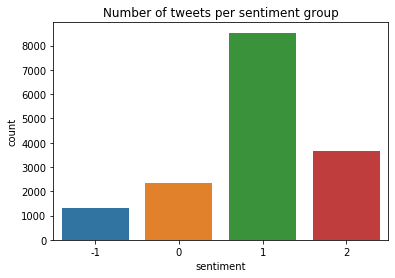

In [16]:
# Bar plot displaying the count of each sentiment for the dataframe
sns.countplot(train['sentiment'])
plt.title('Number of tweets per sentiment group')
plt.show()

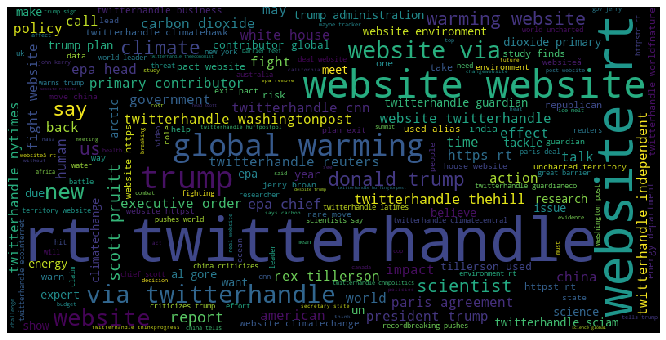

In [17]:
#Wordcloud of tweets for news
wordcloud = WordCloud(background_color='black', width=800, height=400).generate(' '.join(train[train['sentiment'] == 2]
                                          ['clean_msg']))
plt.figure( figsize=(12,6))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

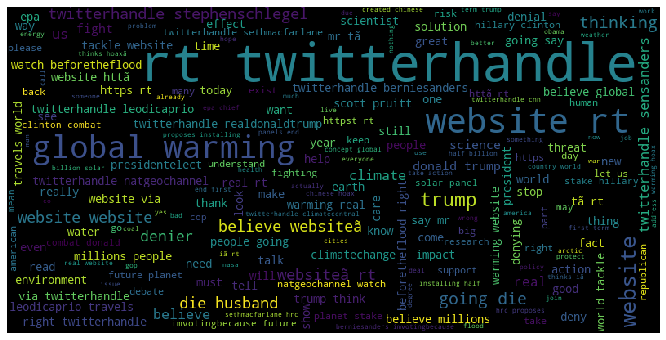

In [18]:
#Wordcloud of tweets for pro climate change
wordcloud = WordCloud(background_color='black', width=800, height=400).generate(' '.join(train[train['sentiment'] == 1]
                                          ['clean_msg']))
plt.figure( figsize=(12,6))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

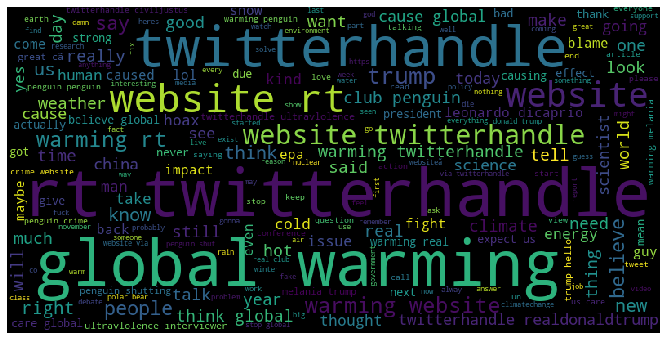

In [19]:
#Wordcloud of tweets for neutral 
wordcloud = WordCloud(background_color='black', width=800, height=400).generate(' '.join(train[train['sentiment'] == 0]
                                          ['clean_msg']))
plt.figure( figsize=(12,6))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

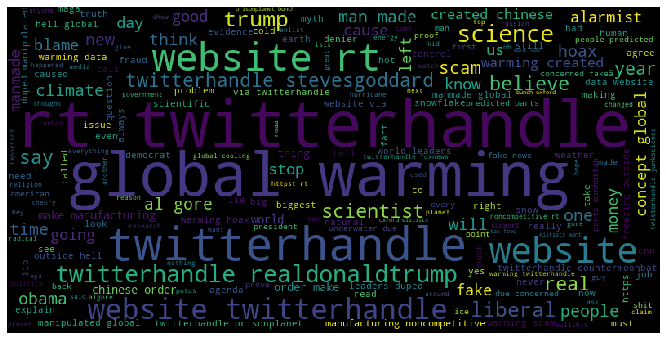

In [20]:
#Wordcloud of tweets for anti climate change
wordcloud = WordCloud(background_color='black', width=800, height=400).generate(' '.join(train[train['sentiment'] == -1]
                                          ['clean_msg']))
plt.figure( figsize=(12,6))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [21]:
# Creating a variable for the sentiment analyser as it is too long
sid = SentimentIntensityAnalyzer()

#Sentiment analysis of cleaned tweets
train['pos']  = train['message'].apply(lambda review: sid.polarity_scores(review)).apply(lambda score_dict: score_dict['pos'])
train['neg']  = train['message'].apply(lambda review: sid.polarity_scores(review)).apply(lambda score_dict: score_dict['neg'])
train['neu']  = train['message'].apply(lambda review: sid.polarity_scores(review)).apply(lambda score_dict: score_dict['neu'])
train['compound']  = train['message'].apply(lambda review: sid.polarity_scores(review)).apply(lambda score_dict: score_dict['compound'])

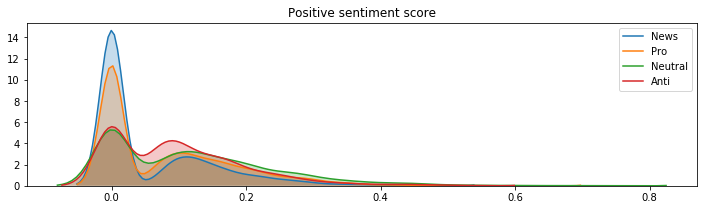

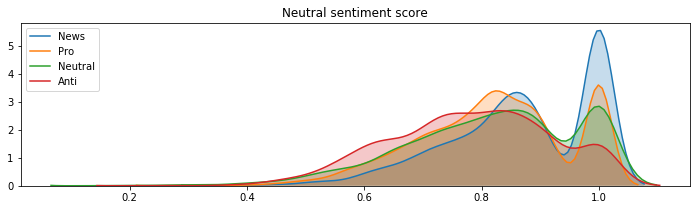

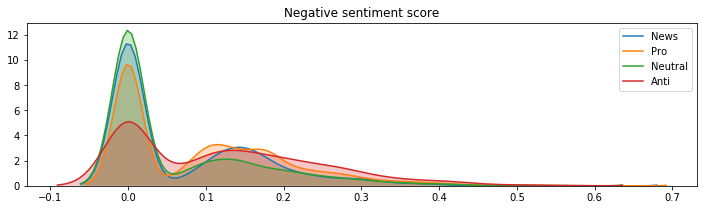

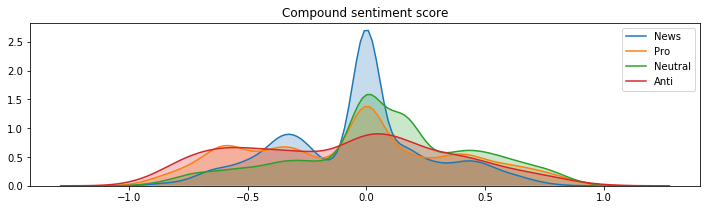

In [22]:
plt.figure( figsize=(12,3) )
sns.kdeplot(train['pos'][train['sentiment'] == 2], shade = True, label = 'News')
sns.kdeplot(train['pos'][train['sentiment'] == 1], shade = True, label = 'Pro')
sns.kdeplot(train['pos'][train['sentiment'] == 0], shade = True, label = 'Neutral')
sns.kdeplot(train['pos'][train['sentiment'] == -1], shade = True, label = 'Anti')
plt.xlabel('')
plt.title('Positive sentiment score')
plt.show()

plt.figure( figsize=(12,3) )
sns.kdeplot(train['neu'][train['sentiment'] == 2], shade = True, label = 'News')
sns.kdeplot(train['neu'][train['sentiment'] == 1], shade = True, label = 'Pro')
sns.kdeplot(train['neu'][train['sentiment'] == 0], shade = True, label = 'Neutral')
sns.kdeplot(train['neu'][train['sentiment'] == -1], shade = True, label = 'Anti')
plt.xlabel('')
plt.title('Neutral sentiment score')
plt.show()

plt.figure( figsize=(12,3) )
sns.kdeplot(train['neg'][train['sentiment'] == 2], shade = True, label = 'News')
sns.kdeplot(train['neg'][train['sentiment'] == 1], shade = True, label = 'Pro')
sns.kdeplot(train['neg'][train['sentiment'] == 0], shade = True, label = 'Neutral')
sns.kdeplot(train['neg'][train['sentiment'] == -1], shade = True, label = 'Anti')
plt.xlabel('')
plt.title('Negative sentiment score')
plt.show()

plt.figure( figsize=(12,3) )
sns.kdeplot(train['compound'][train['sentiment'] == 2], shade = True, label = 'News')
sns.kdeplot(train['compound'][train['sentiment'] == 1], shade = True, label = 'Pro')
sns.kdeplot(train['compound'][train['sentiment'] == 0], shade = True, label = 'Neutral')
sns.kdeplot(train['compound'][train['sentiment'] == -1], shade = True, label = 'Anti')
plt.xlabel('')
plt.title('Compound sentiment score')
plt.show()

In [23]:
#add word count
train['word_count'] = train['message'].apply(lambda x: len(x.split()))

#add unique word count
train['unique_words'] = train['message'].apply(lambda x: len(set(x.split())))

#add stopword count
stop_words = list(stopwords.words("english"))
train['number_stopwords'] = train['message'].apply(lambda x: len([i for i in x.lower().split() if i in stop_words]))

#add punctuation count
train['punctuation'] = train['message'].apply(lambda x: len([i for i in str(x) if i in string.punctuation]))

#add url count
train['number_urls'] = train['message'].apply(lambda x: len([i for i in x.lower().split() if 'http' in i or 'https' in i]))

#add mention count
train['mentions'] = train['message'].apply(lambda x: len([i for i in str(x) if i == '@']))

#add hashtag count
train['hashtags'] = train['message'].apply(lambda x: len([i for i in str(x) if i == '#']))

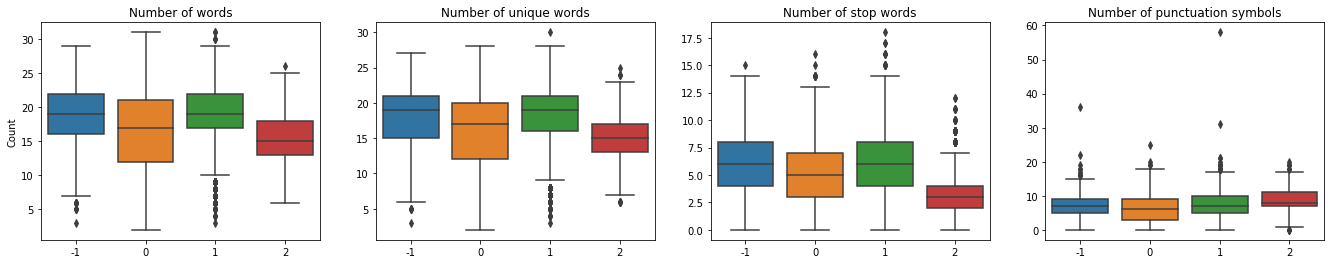

In [24]:
plt.subplot(1,4,1)
sns.boxplot(y='word_count', x='sentiment', data=train)
plt.title('Number of words')
plt.ylabel('Count')
plt.xlabel('')
fig = plt.gcf()
fig.set_size_inches( 23, 5)

plt.subplot(1,4,2)
sns.boxplot(y='unique_words', x='sentiment', data=train)
plt.title('Number of unique words')
plt.ylabel('')
plt.xlabel('')
fig = plt.gcf()
fig.set_size_inches( 23, 5)

plt.subplot(1,4,3)
sns.boxplot(y='number_stopwords', x='sentiment', data=train)
plt.title('Number of stop words')
plt.ylabel('')
plt.xlabel('')
fig = plt.gcf()
fig.set_size_inches( 23, 5)

plt.subplot(1,4,4)
sns.boxplot(y='punctuation', x='sentiment', data=train)
plt.title('Number of punctuation symbols')
plt.ylabel('')
plt.xlabel('')
fig = plt.gcf()
fig.set_size_inches( 23, 4)
plt.show()

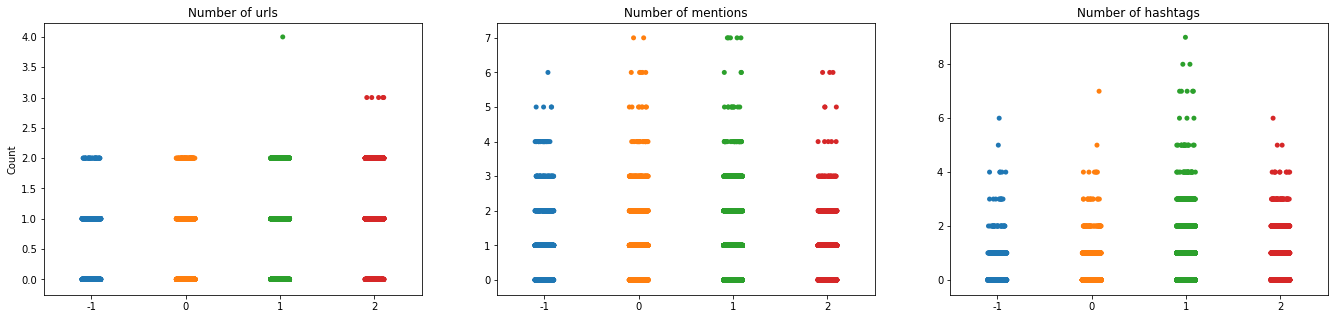

In [25]:
plt.subplot(1,3,1)
sns.stripplot(y='number_urls', x='sentiment', data=train, jitter=True)
plt.title('Number of urls')
plt.ylabel('Count')
plt.xlabel('')
fig = plt.gcf()
fig.set_size_inches( 23, 5)

plt.subplot(1,3,2)
sns.stripplot(y='mentions', x='sentiment', data=train, jitter=True)
plt.title('Number of mentions')
plt.ylabel('')
plt.xlabel('')
fig = plt.gcf()
fig.set_size_inches( 23, 5)

plt.subplot(1,3,3)
sns.stripplot(y='hashtags', x='sentiment', data=train, jitter=True)
plt.title('Number of hashtags')
plt.ylabel('')
plt.xlabel('')
fig = plt.gcf()
fig.set_size_inches( 23, 5)

plt.show()

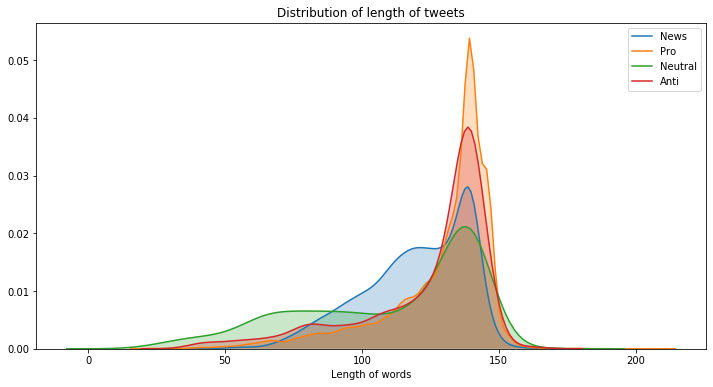


Average length of news tweets:		119.92

Average length of pro tweets:		128.971

Average length of neutral tweets:	110.925

Average length of con tweets:		123.725


In [26]:
train['length'] = train['message'].apply(len)

plt.figure( figsize=(12,6) )
sns.kdeplot(train['length'][train['sentiment'] == 2], shade = True, label = 'News')
sns.kdeplot(train['length'][train['sentiment'] == 1], shade = True, label = 'Pro')
sns.kdeplot(train['length'][train['sentiment'] == 0], shade = True, label = 'Neutral')
sns.kdeplot(train['length'][train['sentiment'] == -1], shade = True, label = 'Anti')
plt.xlabel('Length of words')
plt.title('Distribution of length of tweets')
plt.show()

print('\n' + 'Average length of news tweets:\t\t{}'.format(round(train['length'][train['sentiment'] == 2].mean(), 3)))
print('\n' + 'Average length of pro tweets:\t\t{}'.format(round(train['length'][train['sentiment'] == 1].mean(), 3)))
print('\n' + 'Average length of neutral tweets:\t{}'.format(round(train['length'][train['sentiment'] == 0].mean(), 3)))
print('\n' + 'Average length of con tweets:\t\t{}'.format(round(train['length'][train['sentiment'] == -1].mean(), 3)))

In [27]:
def count_pos(df, sentiment):
    pos_dict = {}
    df_pos = df[df['sentiment'] == sentiment]
    for i in range(len(df_pos)):
        text = nlp(df.iloc[i, 1])
        for j in range(len(text)):
            part_of_speech = text[j].pos_
            if part_of_speech in pos_dict.keys():
                pos_dict[part_of_speech] += 1
            else:
                pos_dict[part_of_speech] = 1
    return pos_dict

In [28]:
grp_2_pos = pd.DataFrame.from_dict(count_pos(train, 2), orient='index', columns=['News'])
grp_1_pos = pd.DataFrame.from_dict(count_pos(train, 1), orient='index', columns=['Pro'])
grp_0_pos = pd.DataFrame.from_dict(count_pos(train, 0), orient='index', columns=['Neutral'])
grp_neg1_pos = pd.DataFrame.from_dict(count_pos(train, -1), orient='index', columns=['Anti'])

grp_2_pos['News'] = grp_2_pos['News']/(len(train[train['sentiment'] == 2]))
grp_1_pos['Pro'] = grp_1_pos['Pro']/(len(train[train['sentiment'] == 1]))
grp_0_pos['Neutral'] = grp_0_pos['Neutral']/(len(train[train['sentiment'] == 0]))
grp_neg1_pos['Anti'] = grp_neg1_pos['Anti']/(len(train[train['sentiment'] == -1]))

train_pos = pd.merge(grp_2_pos, grp_1_pos, how='outer', left_index=True, right_index=True)
train_pos = pd.merge(train_pos, grp_0_pos, how='outer', left_index=True, right_index=True)
train_pos = pd.merge(train_pos, grp_neg1_pos, how='outer', left_index=True, right_index=True)

train_pos['type'] = train_pos.index
train_pos = pd.melt(train_pos, id_vars='type', var_name="sentiment", value_name="count")

C:\Users\rober\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


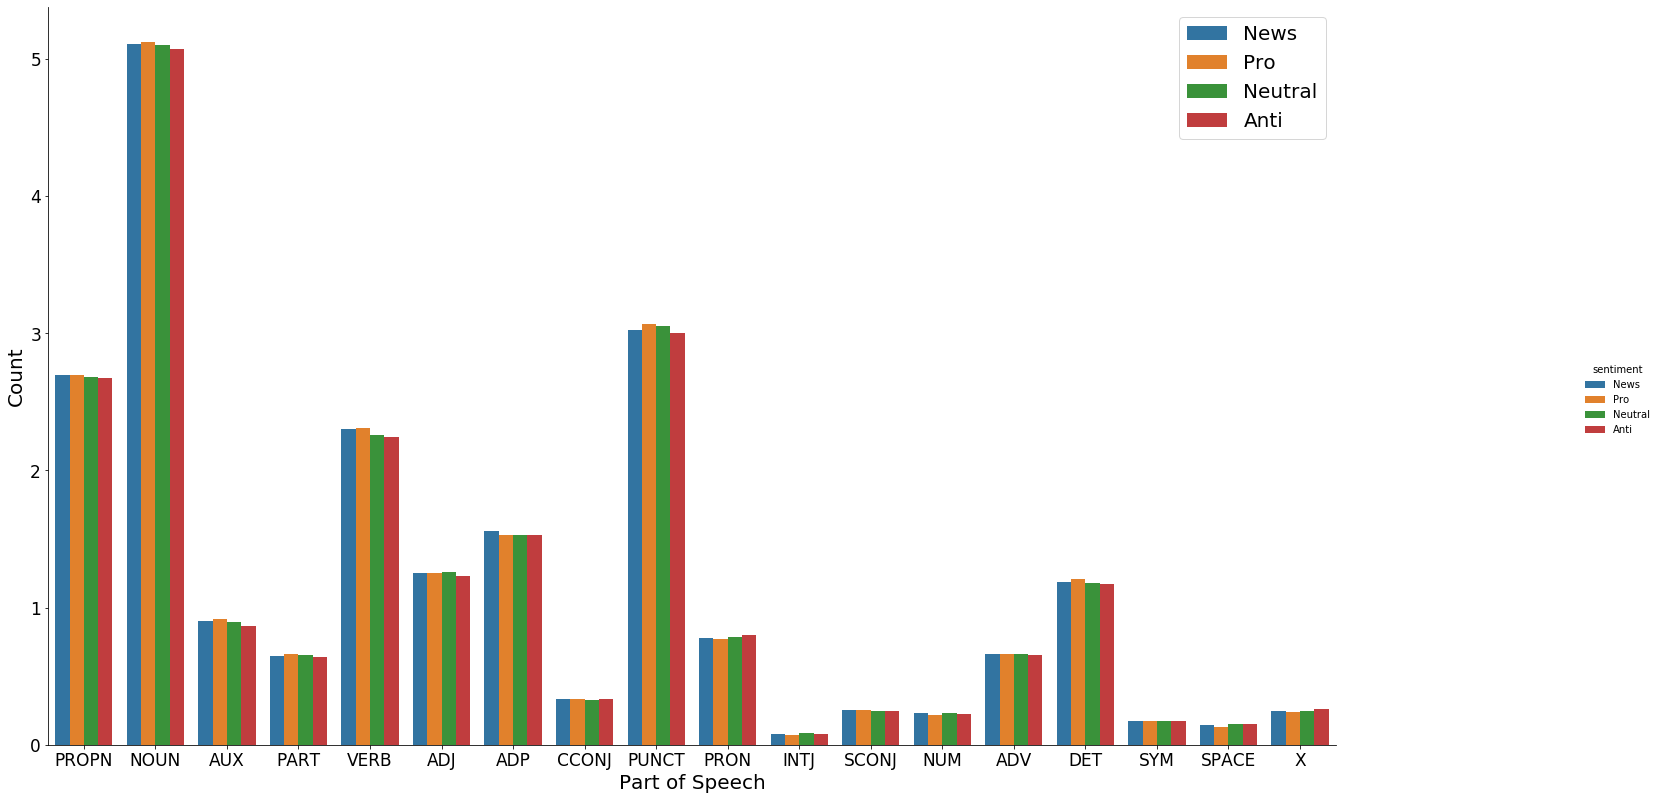

In [29]:
sns.factorplot(x='type', y='count', hue='sentiment', data=train_pos, kind='bar')
plt.xlabel('Part of Speech', size=20)
plt.ylabel('Count', size=20)
plt.xticks(size = 17)
plt.yticks(size = 17)
plt.legend(prop={'size':20})
fig = plt.gcf()
fig.set_size_inches(25, 12)
plt.show()

In [30]:
def count_ent(df, sentiment):
    ent_dict = {}
    name_dict = {}
    df_pos = df[df['sentiment'] == sentiment]
    for i in range(len(df_pos)):
        text = nlp(df.iloc[i, 1])
        if text.ents:
            for ent in text.ents:
                if ent.label_ in ent_dict.keys():
                    ent_dict[ent.label_] += 1
                else:
                    ent_dict[ent.label_] = 1
    return ent_dict

In [31]:
grp_2_ent = pd.DataFrame.from_dict(count_ent(train, 2), orient='index', columns=['News'])
grp_1_ent = pd.DataFrame.from_dict(count_ent(train, 1), orient='index', columns=['Pro'])
grp_0_ent = pd.DataFrame.from_dict(count_ent(train, 0), orient='index', columns=['Neutral'])
grp_neg1_ent = pd.DataFrame.from_dict(count_ent(train, -1), orient='index', columns=['Anti'])

grp_2_ent['News'] = grp_2_ent['News']/(len(train[train['sentiment'] == 2]))
grp_1_ent['Pro'] = grp_1_ent['Pro']/(len(train[train['sentiment'] == 1]))
grp_0_ent['Neutral'] = grp_0_ent['Neutral']/(len(train[train['sentiment'] == 0]))
grp_neg1_ent['Anti'] = grp_neg1_ent['Anti']/(len(train[train['sentiment'] == -1]))

train_ent = pd.merge(grp_2_ent, grp_1_ent, how='outer', left_index=True, right_index=True)
train_ent = pd.merge(train_ent, grp_0_ent, how='outer', left_index=True, right_index=True)
train_ent = pd.merge(train_ent, grp_neg1_ent, how='outer', left_index=True, right_index=True)

train_ent['type'] = train_ent.index
train_ent = pd.melt(train_ent, id_vars='type', var_name="sentiment", value_name="count")

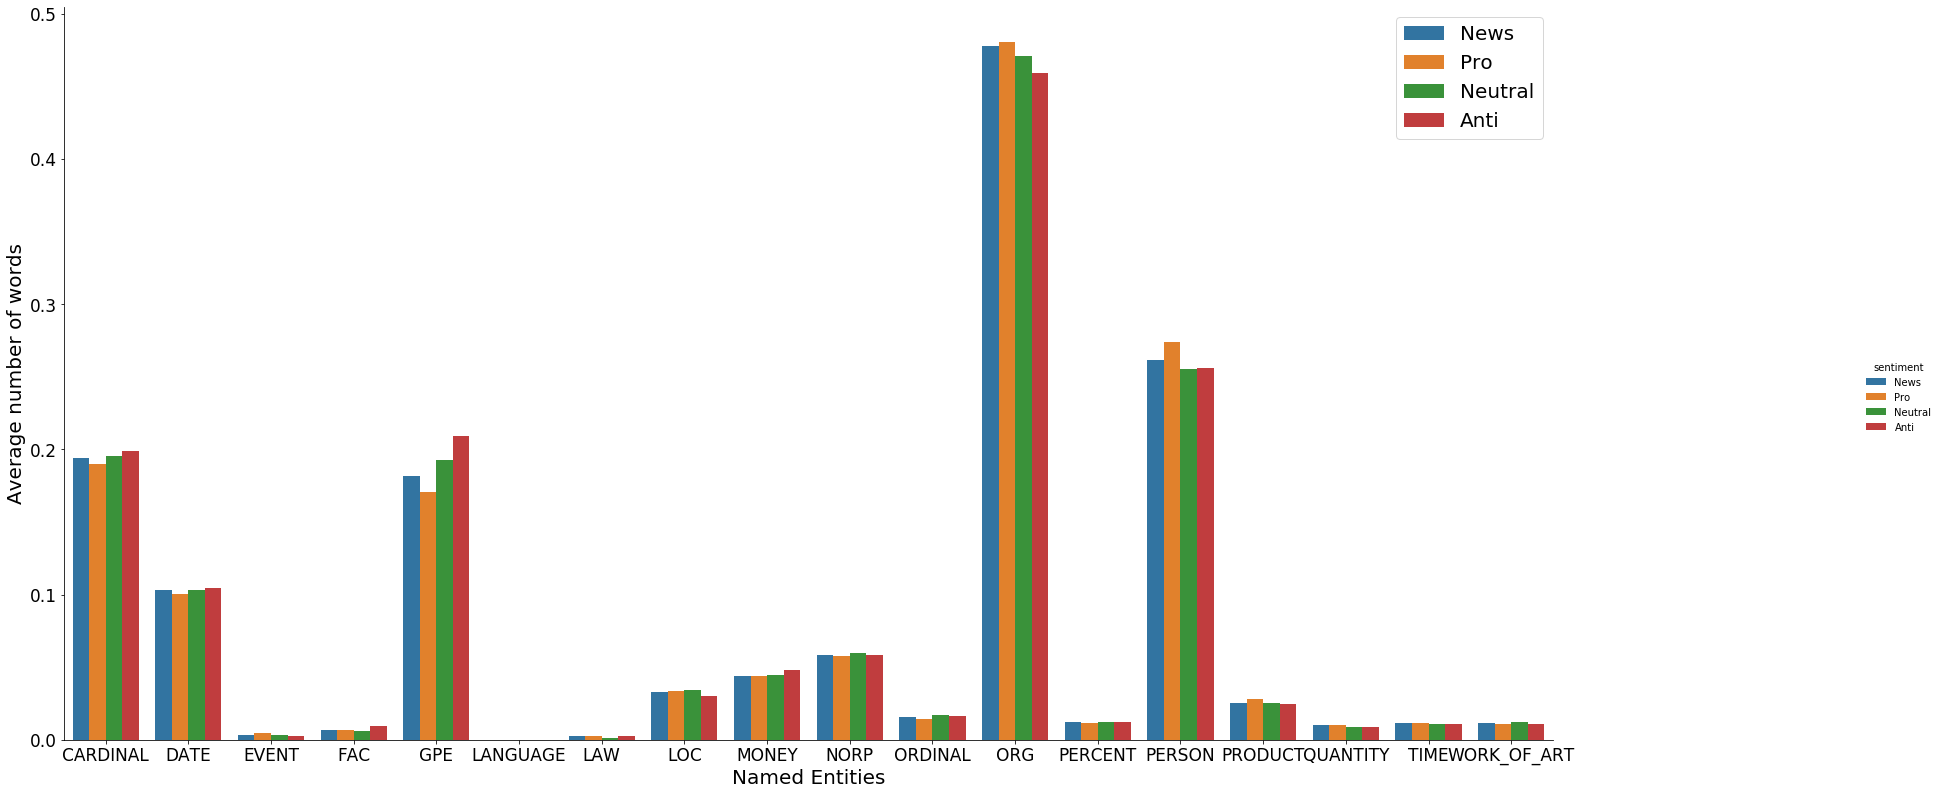

In [32]:
sns.factorplot(x='type', y='count', hue='sentiment', data=train_ent, kind='bar')
plt.xlabel('Named Entities', size=20)
plt.ylabel('Average number of words', size=20)
plt.xticks(size = 17)
plt.yticks(size = 17)
plt.legend(prop={'size':20})
fig = plt.gcf()
fig.set_size_inches(30, 12)
plt.show()

## Modelling

In [33]:
vectorizer = TfidfVectorizer(sublinear_tf=True, 
                             smooth_idf = True, 
                             max_df = 0.3, 
                             strip_accents = 'ascii', 
                             ngram_range = (1, 2))

In [34]:
# Splitting the data into variable and response 
X = vectorizer.fit_transform(train['clean_msg'].values)
y = train['sentiment'].values

print('Shape of the vectorised training data: {}'.format(X.shape))

Shape of the vectorised training data: (15819, 122832)


## Split data into train and validation sets

In [35]:
# Splitting the training data into training (80%) and validation (20%) sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

## Model evaluation

In [36]:
# Evaluate the F1 score of different classifier models by cross-validation
random_state = 42
kf = KFold(n_splits=10, random_state=random_state, shuffle=True)

clf = [LogisticRegression(max_iter = 4000), 
       LinearSVC(random_state=random_state),  
       ComplementNB()]

scores = []
for i in range(len(clf)):
    scores.append(cross_val_score(clf[i], X_train, y_train, 
                                  scoring=make_scorer(f1_score, average='macro'), 
                                  cv=kf).mean())

result = pd.DataFrame({'Algorithm': ['LR', 'LSVC', 'CNB'], 'F1_macro': scores})
result = result.sort_values('F1_macro', ascending=False)

print(result)

  Algorithm  F1_macro
1      LSVC  0.629356
2       CNB  0.608490
0        LR  0.529686


In [37]:
# Compare results of best performing versus worst performing model
## Best performing model: LinearSVC()
clf = LinearSVC(random_state=random_state)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_valid)

print('Best model performance' + '\n')
print('Accuracy: {}'.format(accuracy_score(y_valid, y_pred)))
print('Precision: {}'.format(precision_score(y_valid, y_pred, average='macro')))
print('Recall: {}'.format(recall_score(y_valid, y_pred, average='macro')))
print('F1: {}'.format(f1_score(y_valid, y_pred, average='macro')))
print('\n' + classification_report(y_valid, y_pred))

Best model performance

Accuracy: 0.7364096080910241
Precision: 0.7686970169067815
Recall: 0.5706449131271415
F1: 0.6191118156456629

              precision    recall  f1-score   support

          -1       0.85      0.33      0.47       259
           0       0.69      0.32      0.44       471
           1       0.71      0.92      0.80      1706
           2       0.82      0.71      0.76       728

    accuracy                           0.74      3164
   macro avg       0.77      0.57      0.62      3164
weighted avg       0.75      0.74      0.71      3164



In [38]:
# Compare results of best performing versus worst performing model
## Worst performing model: LinearSVC()
clf = KNeighborsClassifier(3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_valid)

print('Worst model performance' + '\n')
print('Accuracy: {}'.format(accuracy_score(y_valid, y_pred)))
print('Precision: {}'.format(precision_score(y_valid, y_pred, average='macro')))
print('Recall: {}'.format(recall_score(y_valid, y_pred, average='macro')))
print('F1: {}'.format(f1_score(y_valid, y_pred, average='macro')))
print('\n' + classification_report(y_valid, y_pred))

Worst model performance

Accuracy: 0.31763590391908975
Precision: 0.7555114258784135
Recall: 0.3802042848369601
F1: 0.29512337706497777

              precision    recall  f1-score   support

          -1       0.96      0.09      0.16       259
           0       0.18      0.99      0.30       471
           1       0.99      0.20      0.33      1706
           2       0.90      0.24      0.38       728

    accuracy                           0.32      3164
   macro avg       0.76      0.38      0.30      3164
weighted avg       0.84      0.32      0.32      3164



## Hyperparameter tuning

In [39]:
# Specify the range of 'C' parameters for LinearSVC
params = {'C': [0.1, 0.5, 1, 5, 10]}

clf = GridSearchCV(LinearSVC(max_iter=4000, multi_class='ovr'), 
                   param_grid=params, cv=kf, 
                   scoring=make_scorer(f1_score, average='macro')).fit(X_train, y_train)

print('Best score: {}'.format(clf.best_score_))
print('Best parameters: {}'.format(clf.best_params_))

Best score: 0.6463602298870297
Best parameters: {'C': 10}


In [40]:
svc = LinearSVC(random_state=random_state, C=clf.best_params_['C'], multi_class='ovr')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_valid)

svc_tuned = LinearSVC(random_state=random_state)
svc_tuned.fit(X_train, y_train)
y_pred_tuned = svc_tuned.predict(X_valid)

print('LinearSVC model performance' + '\n')
print('Accuracy: {}'.format(accuracy_score(y_valid, y_pred)) + 
      '  >>>  {}'.format(accuracy_score(y_valid, y_pred_tuned)))
print('Precision: {}'.format(precision_score(y_valid, y_pred, average='macro')) + 
      '  >>>  {}'.format(precision_score(y_valid, y_pred_tuned, average='macro')))
print('Recall: {}'.format(recall_score(y_valid, y_pred, average='macro')) + 
      '  >>>  {}'.format(recall_score(y_valid, y_pred_tuned, average='macro')))
print('F1: {}'.format(f1_score(y_valid, y_pred, average='macro')) + 
      '  >>>  {}'.format(f1_score(y_valid, y_pred_tuned, average='macro')))
#print('\n' + classification_report(y_test, y_pred) + 
#      '  >>>  {}'.format(classification_report(y_test, y_pred_tuned)))
print('\n' + classification_report(y_valid, y_pred))
print('\n' + classification_report(y_valid, y_pred_tuned) + '\n')

LinearSVC model performance

Accuracy: 0.7395701643489254  >>>  0.7364096080910241
Precision: 0.7417380046950767  >>>  0.7686970169067815
Recall: 0.589809773064733  >>>  0.5706449131271415
F1: 0.6333000403112325  >>>  0.6191118156456629

              precision    recall  f1-score   support

          -1       0.79      0.36      0.49       259
           0       0.65      0.37      0.47       471
           1       0.73      0.90      0.81      1706
           2       0.81      0.73      0.77       728

    accuracy                           0.74      3164
   macro avg       0.74      0.59      0.63      3164
weighted avg       0.74      0.74      0.72      3164


              precision    recall  f1-score   support

          -1       0.85      0.33      0.47       259
           0       0.69      0.32      0.44       471
           1       0.71      0.92      0.80      1706
           2       0.82      0.71      0.76       728

    accuracy                           0.74      3164


In [41]:
#Specify the range of alpha parameters for ComplementNB
params = {'alpha': [0.1, 0.5, 1], 
          'norm': [True, False]}

clf2 = GridSearchCV(ComplementNB(), 
                   param_grid=params, 
                   cv=kf, scoring=make_scorer(f1_score, average='macro')).fit(X_train, y_train)

print('Best score: {}'.format(clf2.best_score_))
print('Best parameters: {}'.format(clf2.best_params_))

Best score: 0.6113439709809916
Best parameters: {'alpha': 0.5, 'norm': True}


In [42]:
cnb = ComplementNB(alpha=clf2.best_params_['alpha'], norm=clf2.best_params_['norm'])
cnb.fit(X_train, y_train)
y_pred = cnb.predict(X_valid)

cnb_tuned = ComplementNB()
cnb_tuned.fit(X_train, y_train)
y_pred_tuned = cnb_tuned.predict(X_valid)

print('ComplementNB model performance' + '\n')
print('Accuracy: {}'.format(accuracy_score(y_valid, y_pred)) + 
      '  >>>  {}'.format(accuracy_score(y_valid, y_pred_tuned)))
print('Precision: {}'.format(precision_score(y_valid, y_pred, average='macro')) + 
      '  >>>  {}'.format(precision_score(y_valid, y_pred_tuned, average='macro')))
print('Recall: {}'.format(recall_score(y_valid, y_pred, average='macro')) + 
      '  >>>  {}'.format(recall_score(y_valid, y_pred_tuned, average='macro')))
print('F1: {}'.format(f1_score(y_valid, y_pred, average='macro')) + 
      '  >>>  {}'.format(f1_score(y_valid, y_pred_tuned, average='macro')))
#print('\n' + classification_report(y_test, y_pred) + 
#      '  >>>  {}'.format(classification_report(y_test, y_pred_tuned)))
print('\n' + classification_report(y_valid, y_pred))
print('\n' + classification_report(y_valid, y_pred_tuned) + '\n')

ComplementNB model performance

Accuracy: 0.7060682680151706  >>>  0.7032237673830595
Precision: 0.6278156516564771  >>>  0.6225522672577274
Recall: 0.6137544089708986  >>>  0.6048323412826087
F1: 0.605902520963333  >>>  0.6025439375709414

              precision    recall  f1-score   support

          -1       0.41      0.49      0.45       259
           0       0.64      0.34      0.44       471
           1       0.78      0.78      0.78      1706
           2       0.68      0.84      0.75       728

    accuracy                           0.71      3164
   macro avg       0.63      0.61      0.61      3164
weighted avg       0.71      0.71      0.70      3164


              precision    recall  f1-score   support

          -1       0.42      0.46      0.44       259
           0       0.61      0.34      0.44       471
           1       0.77      0.78      0.78      1706
           2       0.69      0.83      0.75       728

    accuracy                           0.70      31

## Prediction

In [43]:
X_test_actual = vectorizer.transform(test['clean_msg'].values)

In [44]:
# Running a prediction on the test data
classifier = LinearSVC(max_iter=4000)
linearsvc = classifier.fit(X, y)
y_pred = classifier.predict(X_test_actual)

In [45]:
# Storing the predictions in a CSV
predictions = pd.DataFrame({"tweetid":test.index, "sentiment": y_pred})
predictions.to_csv('final_submission_stratified.csv', index=False)
predictions.head()

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,0
